In [57]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]

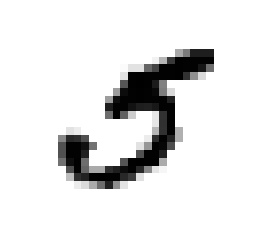

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
# Let’s also shuffle the training set; this will guarantee that all cross-validation folds 
# will be similar (you don’t want one fold to be missing some digits). Moreover, some 
# learning algorithms are sensitive to the order of the training instances, and they perform 
# poorly if they get many similar instances in a row.
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Training a binary classifier
===============

First implement a detector. A classifier who can distinguish between 5 and non-5.

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [58]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

Implementing cross-validation
===============

K-Folds cross validation splits data into K parts and trains the model
on a partition of (K-1) parts of the data and tests it on the remaining part.

Repeats this process K times, and outputs how well the model did each time.

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print (n_correct / len(y_pred))
    
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

0.9537
0.94695
0.9679


array([ 0.9537 ,  0.94695,  0.9679 ])

A much better way to evaluate the performance of a classifier is to look at the **confusion matrix**.

In [60]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53063,  1516],
       [ 1113,  4308]], dtype=int64)

In [32]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)
rs = recall_score(y_train_5, y_train_pred)
print(ps)
print(rs)

0.739697802198
0.794687327061


In [36]:
f1 = 2 * (ps * rs) / (ps + rs)
print(f1)

0.766207203201


In [42]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [61]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [46]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

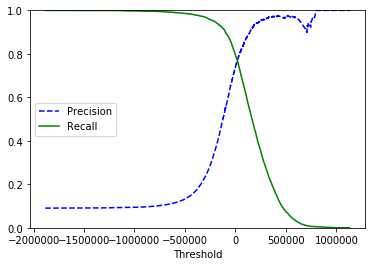

In [49]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [52]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.83299203640500574

The ROC Curve
=======

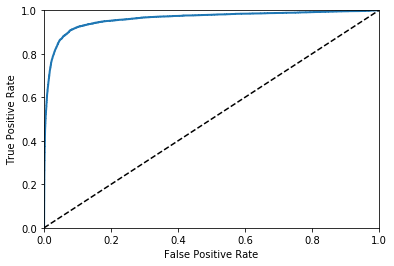

In [63]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [65]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96113580703115697

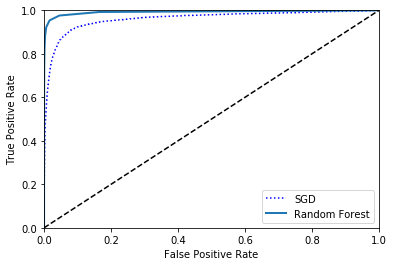

In [67]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [69]:
roc_auc_score(y_train_5, y_scores_forest)

0.99237717927252633

In [70]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [72]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-215505.91600468, -468436.6060117 , -360692.82300714,
        -127222.20607654, -441676.06253779,  137322.04317167,
        -792859.27085244, -341946.6997439 , -690419.54506433,
        -495389.79734665]])

In [74]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [75]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.3,  0. ,  0.6,  0. ,  0. ,  0. ,  0. ]])